# Lecture 10

* K-means
* Mixture of Gaussians
* EM algorithm for the mixture of Gaussians

Import necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import random
import math
import sklearn.datasets as ds
import matplotlib.pyplot as plt
%matplotlib inline

# K-means algorithm

K-means algorithm is implemented in the ```scikit-learn``` package:

In [2]:
from sklearn.cluster import KMeans

To illustrate how you can train this algorithm we generate some toy data and fit the algorithm on these data.

In [3]:
from sklearn.datasets.samples_generator import make_blobs
np.random.seed(0)
centers = [[1, 1], [-1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, 
                            centers=centers, 
                            cluster_std=0.5)

Helper function for data visualization:

In [4]:
def plot_cluster_data(X, c=[1]*X.shape[0], mu=None):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    if len(np.unique(c)) == 1:
        ax.plot(X[:,0], X[:,1], 'o')
    else:
        ix = np.where(c==1)
        ax.plot(X[ix,0], X[ix,1], 'o', 
                markerfacecolor='red')
        ax.plot(mu[0,0], mu[0,1], 'o', 
                markerfacecolor='red', 
                markersize=12)
        ix = np.where(c==0)
        ax.plot(X[ix,0], X[ix,1], 'o', 
                markerfacecolor='green')
        ax.plot(mu[1,0], mu[1,1], 'o', 
                markerfacecolor='green', 
                markersize=12)
    if not mu is None:
        ax.plot(mu[0,0], mu[0,1], 'o', 
                markerfacecolor='red', 
                markersize=12)
        ax.plot(mu[1,0], mu[1,1], 'o', 
                markerfacecolor='green', 
                markersize=12)        
    plt.show()

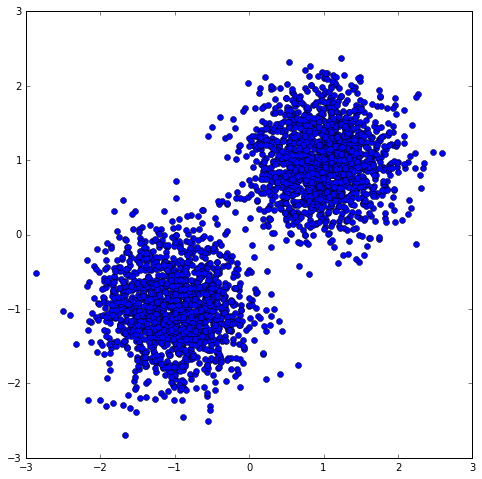

In [5]:
plot_cluster_data(X)

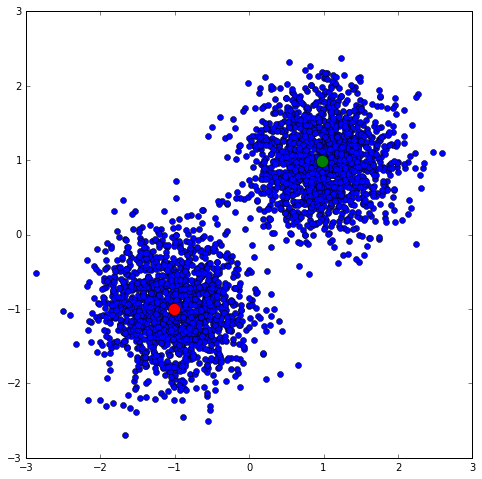

In [6]:
clst = KMeans(n_clusters=2, random_state=2342)
clst.fit(X)
mu = clst.cluster_centers_
plot_cluster_data(X, mu = mu)

Now we show what happens on each step of the algorithm. We will use two additional functions that corresponds to the two steps of the k-means algorithm.

In [7]:
def update_labels(X, mu):
    c = np.argmax(np.c_[np.sum(np.power(X - mu[0,:], 2), axis=1), 
                        np.sum(np.power(X - mu[1,:], 2), axis=1)], 
                  axis=1)
    return c

def update_cluster_centers(X, c):
    ix = np.where(c==1)
    mu[0,:] = np.mean(X[ix,:], axis=1)
    ix = np.where(c==0)
    mu[1,:] = np.mean(X[ix,:], axis=1)
    return mu

First step of algorithm is to choose the number of clusters $k$ and cluster centers randomly.

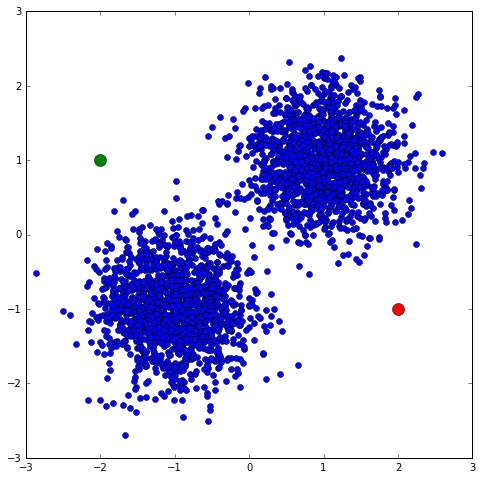

In [8]:
k = 2
mu = np.array([[2.0,-1.0], [-2.0,1.0]])
plot_cluster_data(X, mu=mu)

Now for each point we calculate what is the closest center:

Iteration 0:
...updating labels:


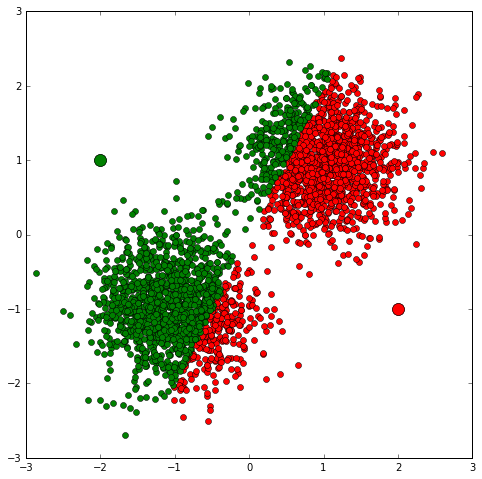

...updating centers:


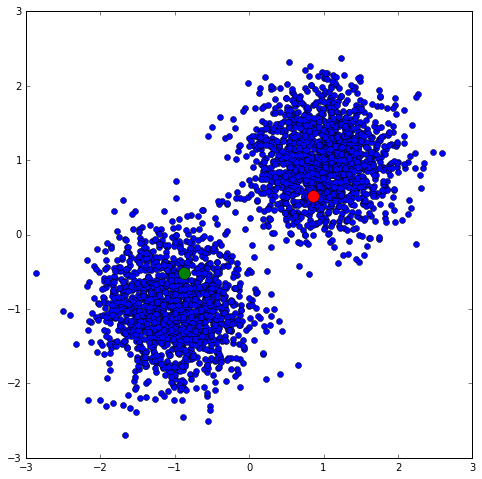

Iteration 1:
...updating labels:


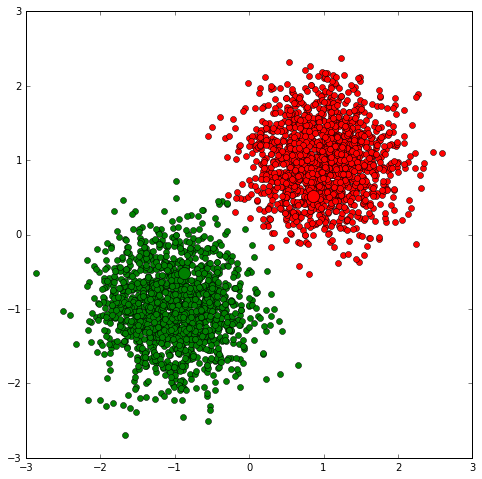

...updating centers:


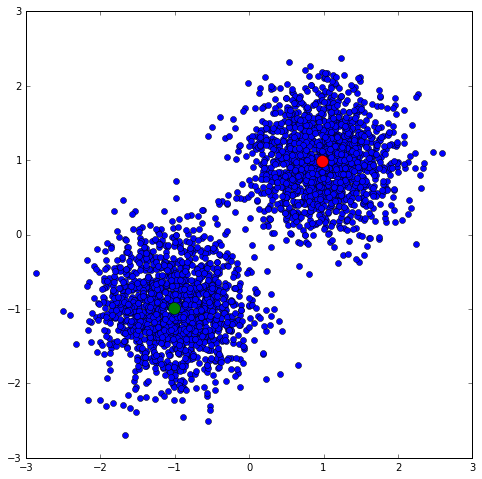

In [9]:
niter = 2
for it in range(niter):
    print 'Iteration ' + str(it) + ':'
    c = update_labels(X, mu)
    print '...updating labels:'
    plot_cluster_data(X, c=c, mu=mu)
    print '...updating centers:'    
    mu = update_cluster_centers(X, c)
    plot_cluster_data(X, mu=mu)    

# Mixture of Gaussians

As an example we generate data based on two different gaussian distributions:

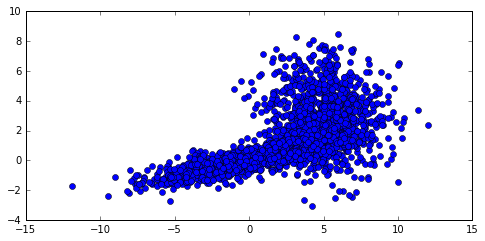

In [10]:
np.random.seed(0)
n_samples = 1000
X1 = 2.0*np.random.randn(n_samples, 2) + np.array([5, 3])
C = np.array([[0., -0.5], [3.5, .7]])
X2 = np.dot(np.random.randn(n_samples, 2), C)
X_train = np.vstack([X1, X2])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train[:,0], X_train[:,1], 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

and train mixture of Gaussians model on these data:

In [11]:
from sklearn.mixture import GMM

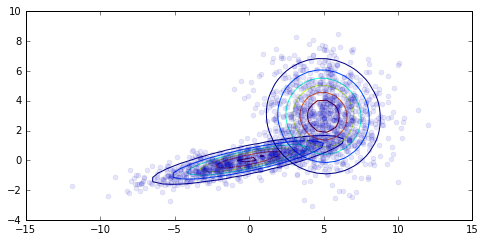

In [12]:
np.random.seed(1)
model = GMM(n_components=2, covariance_type='full')
model.fit(X_train)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train[:,0], X_train[:,1], 'o', alpha=.1, ms=5)

for i in range(2):    
    mu = model.means_[i]
    sigma = model.covars_[i]
    sigma_inv = np.linalg.inv(sigma)
    sigma_det = np.linalg.det(sigma)
    x = np.linspace(-15.0, 15.0)
    y = np.linspace(-4.0, 10.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    XX = np.dot(np.dot(XX - mu, sigma_inv), 
                np.transpose(XX - mu))
    P = np.exp(-0.5*np.diagonal(XX))/(2*np.pi*sigma_det**0.5)
    P = P.reshape(X.shape)
    CS = plt.contour(X, Y, P)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# EM algorithm for the mixture of Gaussians

We implement EM algorithm for the mixture of Gaussians from scratch. First, we define the functions for E-step and M-step. Notice that we have used some built-in ```numpy``` functions to avoid loops.

In [13]:
def Estep(mu, sigma, phi):
    # calculate determinants of sigma's
    det_sigma = np.array([[np.linalg.det(sigma[i])] 
                          for i in range(k)])
    # calculate inverse matrices for sigma's
    inv_sigma = np.array([np.linalg.inv(sigma[i]) 
                          for i in range(k)]).reshape(sigma.shape)
    # calculate Q(z) = p(x|z)*p(z)/p(x)
    pxz = np.array([
            np.exp(
                -0.5*np.diagonal(
                    np.dot(
                        np.dot(X_train - mu[i,:], inv_sigma[i]), 
                        np.transpose(X_train - mu[i,:])
                    )
                )
            )/((2.0*np.pi)**(n/2.0)*det_sigma[i,0]**0.5)*phi[i,0] 
            for i in range(k)]).T
    pz = pxz/np.sum(pxz, axis=1).reshape((-1, 1))
    return pz

def Mstep(pz):
    pz_sum = np.sum(pz, axis=0).reshape((-1,1))
    # update parameters
    phi_new = pz_sum/m
    mu_new = np.transpose(np.dot(X_train.T, pz)/pz_sum.T)
    sigma_new = np.array([
            np.dot(np.array([
                        np.outer(X_train[j,:] - mu_new[i,:], 
                                 X_train[j,:] - mu_new[i,:]) 
                        for j in range(m)]).reshape((m, -1)).T, 
                   pz[:,i]).reshape((n,n))/pz_sum[i,0] 
            for i in range(k)]).reshape((k,n,n))
    return mu_new, sigma_new, phi_new

We use the data from the previous section (generated as a mixture of two gaussian distributions):

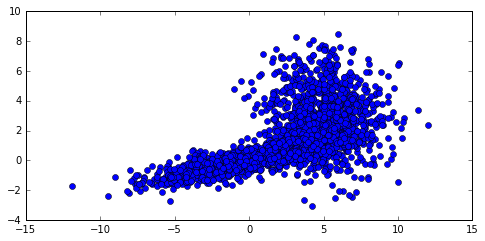

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train[:,0], X_train[:,1], 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Define the variables and parameters for our EM algorithm:

In [15]:
# number of components
k = 2
# number of features
n = X_train.shape[1]
# number of training examples
m = X_train.shape[0]
# number of iterations
niter = 10
# initial values of phi
phi = np.array([1.0/k]*k).reshape((k,-1))
# initial values for mu and sigma
mu = []
sigma = []
np.random.seed(234)
for cl in range(k):
    mu.append(np.mean(X_train[np.random.choice(m, m/2),:], axis=0))
    sigma.append(np.identity(n))
mu = np.array(mu).reshape((k, n))
sigma = np.array(sigma).reshape((k, n, n))

We train the mixture of Gaussians model and plot the fitted distributions after each iteration:

Iteration 1:


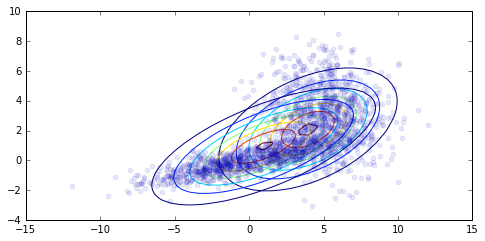

Iteration 2:


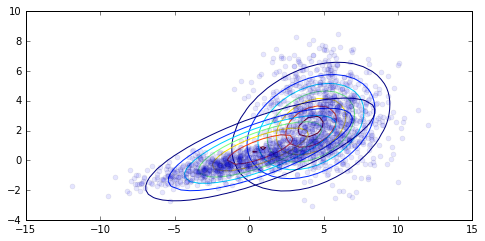

Iteration 3:


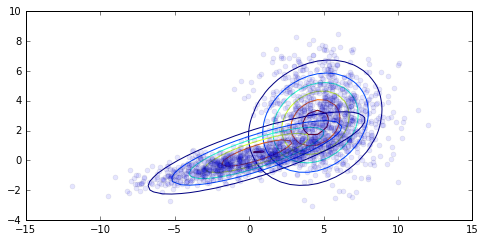

Iteration 4:


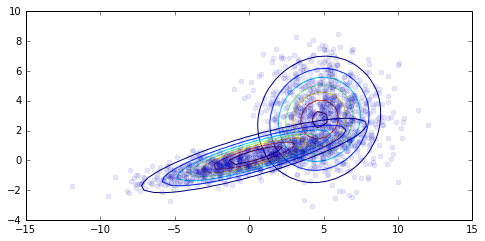

Iteration 5:


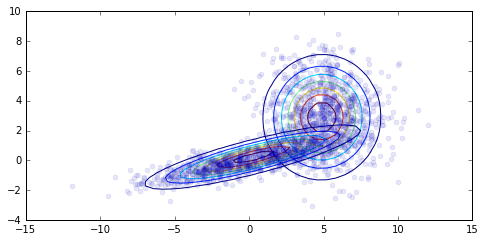

Iteration 6:


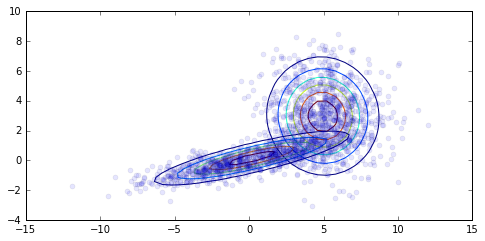

Iteration 7:


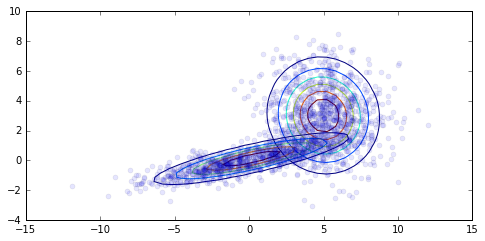

Iteration 8:


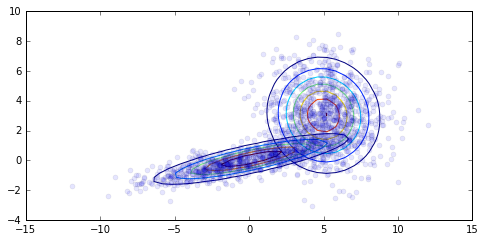

Iteration 9:


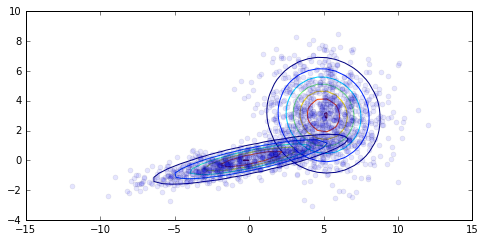

Iteration 10:


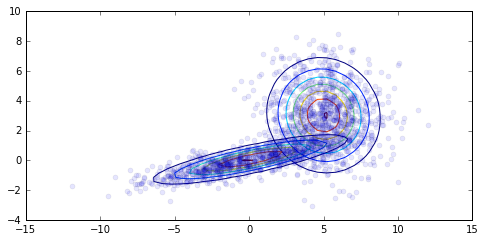

In [16]:
for nit in range(niter):
    print 'Iteration ' + str(nit+1) + ':'
    pz = Estep(mu, sigma, phi)
    mu, sigma, phi = Mstep(pz)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(X_train[:,0], X_train[:,1], 'o', alpha=.1, ms=5)
    for i in range(k):    
        mu_i = mu[i,:]
        sigma_i = sigma[i]
        sigma_i_inv = np.linalg.inv(sigma_i)
        x = np.linspace(-15.0, 15.0)
        y = np.linspace(-4.0, 10.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        P = np.exp(-0.5*np.diagonal(
                np.dot(
                    np.dot(XX - mu_i, sigma_i_inv), 
                    np.transpose(XX - mu_i)
                )))/(2*np.pi*np.linalg.det(sigma_i)**0.5)
        P = P.reshape(X.shape)
        CS = plt.contour(X, Y, P)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()    